# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [1]:
""" Setup the environment for the notebook """
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from utils import yahoo_finance_data_loader as yfdl

data_location = os.path.join(os.getcwd(), 'data', 'raw')

## Data Preprocessing Section

1. Download the data

In [2]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']


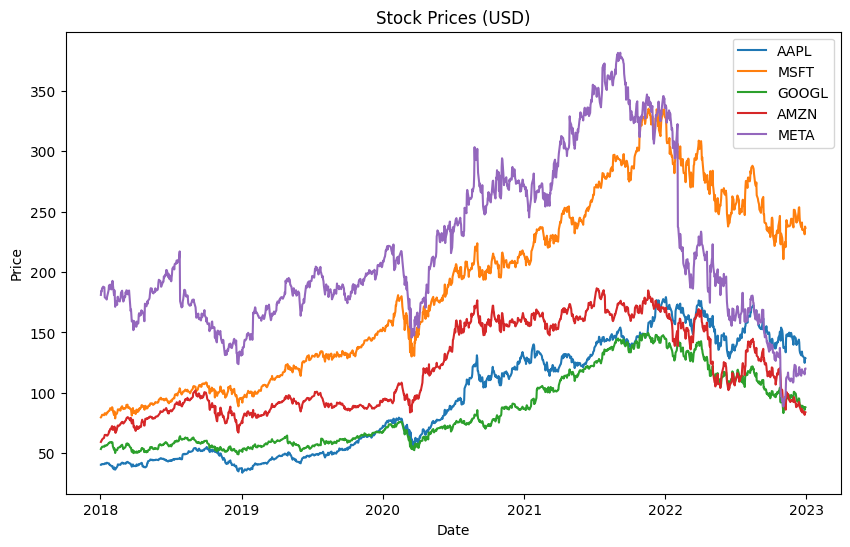

In [3]:
manager = yfdl.TickerManager(STOCK_TICKERS, **DATA_PERIOD)

plt.figure(figsize=(10, 6))
plt.plot(manager['AAPL']['Close'], label='AAPL')
plt.plot(manager['MSFT']['Close'], label='MSFT')
plt.plot(manager['GOOGL']['Close'], label='GOOGL')
plt.plot(manager['AMZN']['Close'], label='AMZN')
plt.plot(manager['META']['Close'], label='META')
plt.title('Stock Prices (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [4]:
manager = yfdl.FinanceLoader(STOCK_TICKERS, **DATA_PERIOD).download(data_location)
print(f"TOTAL TICKERS: {manager.get_ticker_count()}")
manager.finance_data.head()

TOTAL TICKERS: 5


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2018-01-02 00:00:00-05:00,40.074359,40.578350,39.862398,40.568928,102223600,0.0,0.0,AAPL
1,2018-01-03 00:00:00-05:00,40.632509,41.108240,40.498270,40.561855,118071600,0.0,0.0,AAPL
2,2018-01-04 00:00:00-05:00,40.634866,40.853892,40.526533,40.750267,89738400,0.0,0.0,AAPL
3,2018-01-05 00:00:00-05:00,40.846839,41.301371,40.754990,41.214233,94640000,0.0,0.0,AAPL
4,2018-01-08 00:00:00-05:00,41.061146,41.357887,40.962228,41.061146,82271200,0.0,0.0,AAPL


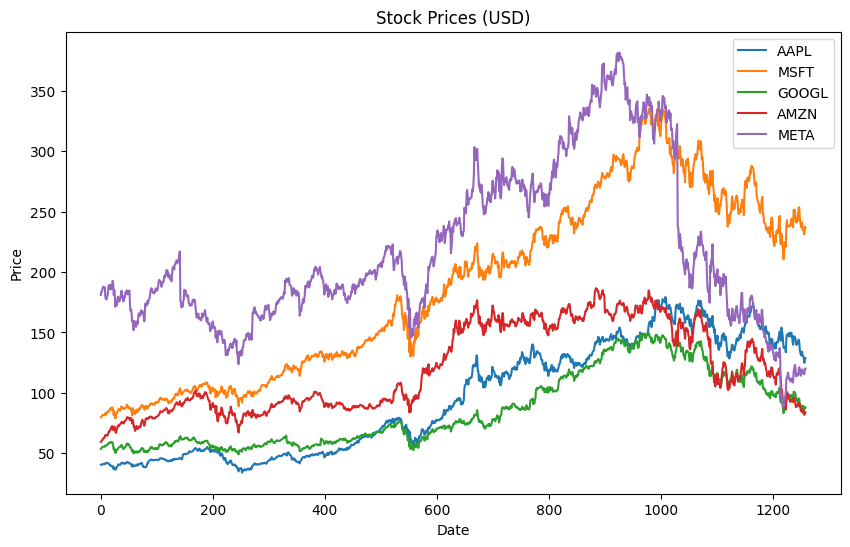

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(manager.finance_data[manager.finance_data['Ticker'] == 'AAPL']['Close'], label='AAPL')
plt.plot(manager.finance_data[manager.finance_data['Ticker'] == 'MSFT']['Close'], label='MSFT')
plt.plot(manager.finance_data[manager.finance_data['Ticker'] == 'GOOGL']['Close'], label='GOOGL')
plt.plot(manager.finance_data[manager.finance_data['Ticker'] == 'AMZN']['Close'], label='AMZN')
plt.plot(manager.finance_data[manager.finance_data['Ticker'] == 'META']['Close'], label='META')
plt.title('Stock Prices (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()